# Field inference for multiple dipole sources

We have shown (`potentials.ipynb`) that it is possible to learn analytical forms like the dipole field with acceptable accuracy through a variety of routes including the scalar and vector potentials. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

## Installation for Apple Silicon
This notebook will need an environment with JAX, Optax, Equinox and their dependencies. On Apple Silicon, this will require using pip to install jax-metal, and then using older versions of optax/equinox compatible with the jax-metal. For updated information, see [Apple's Developer Info](https://developer.apple.com/metal/jax/). These are specified in the package setup.py and can be installed as follows for running this notebook.

```zsh
conda create -n hypermagnetics python=3.9
conda activate hypermagnetics
pip install -e ".[dev]"
```

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt


/Users/berian/miniforge3/envs/hypermagnetics/lib/python3.9/site-packages/jaxtyping/__init__.py:210: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [2]:
def scalar_potential(m, r0, r):
    core = 1.0
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm <= core
    interior = m_dot_r / core / (2 * jnp.pi * core)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)


def magnetic_field(m, r0, r):
    return -jax.grad(scalar_potential, argnums=2)(m, r0, r)


def generate_total(fun, m, r0, r):
    points = jax.vmap(fun, in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    components = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return jnp.sum(components, axis=0)


In [3]:
M = 1
N = 100
key = jr.PRNGKey(41 - 1)
key, subkey = jr.split(key, 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)


2023-11-07 14:51:21.503594: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Ultra

systemMemory: 192.00 GB
maxCacheSize: 72.00 GB



In [14]:
lim, res = 3, 64
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total(scalar_potential, m, r0, flat_grid)
field = generate_total(magnetic_field, m, r0, flat_grid)
print(potential.shape, field.shape)


(100, 4096) (100, 4096, 2)


In [15]:
def plots(x_grid, y_grid, m, r0, potential, field=None, idx=0):
    fig = plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Magnetic Scalar Potential
    cp = axes[0].contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    axes[0].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[0].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[0].set_title("Magnetic Scalar Potential")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    if field is not None:
        # Subplot 2: Magnetic Field
        axes[1].streamplot(
            x_grid,
            y_grid,
            field[idx, :, :, 0],
            field[idx, :, :, 1],
            density=1.0,
            linewidth=1,
            arrowsize=1.5,
            arrowstyle="->",
        )
        axes[1].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
        axes[1].quiver(
            r0[idx, :, 0],
            r0[idx, :, 1],
            m[idx, :, 0],
            m[idx, :, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="red",
        )
        axes[1].set_title("Magnetic Field")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

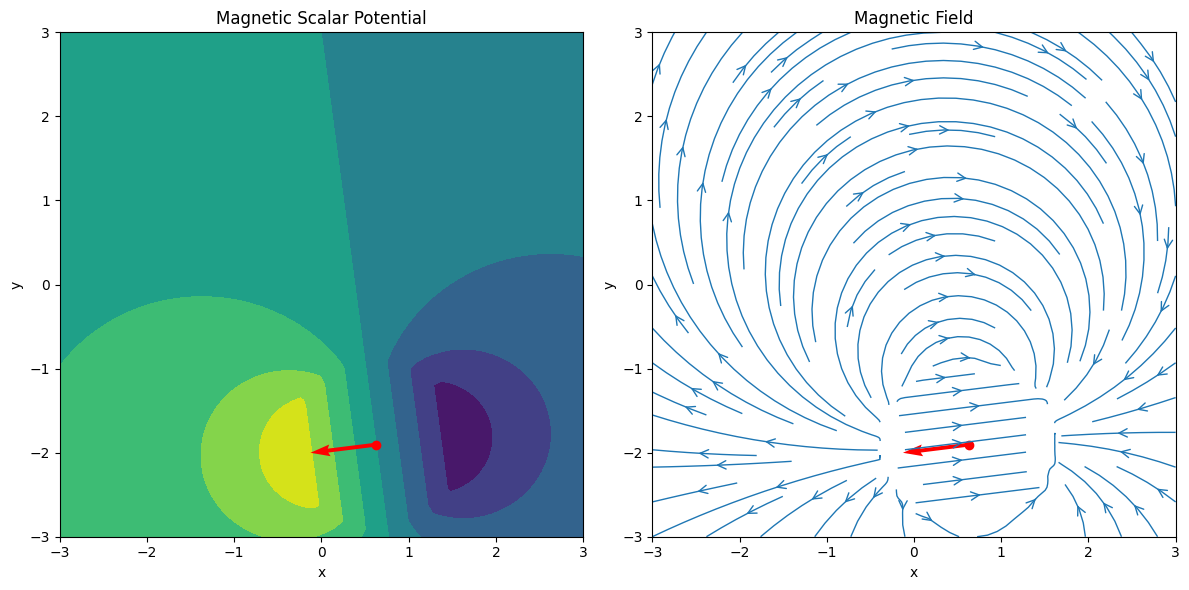

In [16]:
plots(
    x_grid,
    y_grid,
    m,
    r0,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=0,
)


In [17]:
ORDER = 16
omega = 2 * jnp.pi * jnp.arange(1, ORDER + 1) / (4 * lim)
r = flat_grid

def basis_term(fun1, fun2, r):
    return fun1(omega[:, None, None] * r[None, :, 0]) * fun2(
        omega[None, :, None] * r[None, :, 1]
    )

BASIS_TERMS = jnp.stack(
    [
        basis_term(jnp.cos, jnp.cos, r),
        basis_term(jnp.sin, jnp.sin, r),
        basis_term(jnp.cos, jnp.sin, r),
        basis_term(jnp.sin, jnp.cos, r),
    ],
    axis=0,
)


In [18]:
class HyperModel(eqx.Module):
    w: eqx.nn.MLP
    b: eqx.nn.Linear

    def __init__(self, out, width, depth, keys):
        self.w = eqx.nn.MLP(4, out, width, depth, jax.nn.gelu, key=keys.pop())
        self.b = eqx.nn.Linear(4, "scalar", key=keys.pop())

    def __call__(self, m_r):
        return self.w(m_r), self.b(m_r)


class FourierModel(eqx.Module):
    hypermodel: HyperModel
    # w: jnp.ndarray
    # b: jnp.ndarray

    def __init__(self, width, keys):
        self.hypermodel = HyperModel(4 * ORDER**2, width, 3, keys)
        # self.w = jnp.ones((4 * ORDER * ORDER))
        # self.b = jnp.zeros(1)

    def fourier(self, weights, bias, basis_terms=BASIS_TERMS):
        weights = jnp.reshape(weights, (4, ORDER, ORDER))
        elementwise_product = weights[..., None] * basis_terms
        summed_product = jnp.sum(elementwise_product, axis=(0, 1, 2))
        return bias + summed_product

    def prepare_weights(self, m, r0):
        m_r = jnp.concatenate([m, r0], axis=-1)
        w, b = jax.vmap(jax.vmap(self.hypermodel))(m_r)
        return jnp.sum(w, axis=1), jnp.sum(b, axis=1)

    def predict(self, m, r0, r):
        w, b = self.prepare_weights(m, r0)
        # w, b = self.w, self.b
        basis_terms = jnp.stack(
            [
                basis_term(jnp.cos, jnp.cos, r),
                basis_term(jnp.sin, jnp.sin, r),
                basis_term(jnp.cos, jnp.sin, r),
                basis_term(jnp.sin, jnp.cos, r),
            ],
            axis=0,
        )
        return jax.vmap(self.fourier, in_axes=(0, 0, None))(w, b, basis_terms)
        # return self.fourier(w, b, basis_terms)

    def __call__(self, m, r0):
        return jax.vmap(self.fourier)(*self.prepare_weights(m, r0))
        # return self.fourier(self.w, self.b)


@eqx.filter_jit
def loss(model, m, r0, target):
    return jnp.mean(optax.huber_loss(model(m, r0), target))


@eqx.filter_jit
def accuracy(model, m, r0, r, target):
    diff = jnp.abs(target - model.predict(m, r0, r))
    return jnp.median(diff / jnp.abs(target) * 100, axis=1).mean()


In [19]:
key = jr.PRNGKey(42 + 1)
key, *keys = jr.split(key, 5)
width = ORDER * ORDER
model = FourierModel(width, keys)


In [20]:
print(model(m, r0).shape)
print(loss(model, m, r0, potential))
print(accuracy(model, m, r0, flat_grid, potential))
model.predict(m[0:1], r0[0:1], jnp.array([[1.0, 2.0]]))


(100, 4096)
0.44069725
2370.1416


Array([[0.9539118]], dtype=float32)

In [21]:
@eqx.filter_jit
def train_step(model, opt_state, m, r0, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, m, r0, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

@eqx.filter_jit
def validation_set(model, subkey):
    m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)
    r = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkey)
    potential = generate_total(scalar_potential, m, r0, r)
    return accuracy(model, m, r0, r, potential)


optim = optax.adam(learning_rate=1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 50_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    key, subkey = jr.split(key, 2)
    r = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkey)
    model, opt_state, train_loss = train_step(model, opt_state, m, r0, potential)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(accuracy(model, m, r0, flat_grid, potential))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        logger["val_acc"].append(validation_set(model, subkey))
    if (step % (steps / 100)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge = validation_set(model, subkey)
print(f"Final accuracy: {rge:.2f}%")


step=0, train_loss=0.4407,  accuracy=2331.7668 val_accuracy=1816.2450
step=500, train_loss=0.0008,  accuracy=69.9935 val_accuracy=70.4041
step=1000, train_loss=0.0004,  accuracy=48.1217 val_accuracy=57.2932
step=1500, train_loss=0.0003,  accuracy=38.7551 val_accuracy=56.1780
step=2000, train_loss=0.0002,  accuracy=34.3055 val_accuracy=45.1821
step=2500, train_loss=0.0001,  accuracy=28.8886 val_accuracy=49.9444
step=3000, train_loss=0.0001,  accuracy=26.4255 val_accuracy=51.0532
step=3500, train_loss=0.0001,  accuracy=23.7378 val_accuracy=38.9369
step=4000, train_loss=0.0001,  accuracy=23.2114 val_accuracy=49.8342
step=4500, train_loss=0.0001,  accuracy=20.7592 val_accuracy=44.6110
step=5000, train_loss=0.0001,  accuracy=20.7415 val_accuracy=46.0985
step=5500, train_loss=0.0000,  accuracy=19.6904 val_accuracy=35.5273
step=6000, train_loss=0.0000,  accuracy=16.9952 val_accuracy=35.1992
step=6500, train_loss=0.0000,  accuracy=15.6761 val_accuracy=40.1885
step=7000, train_loss=0.0000,  acc

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

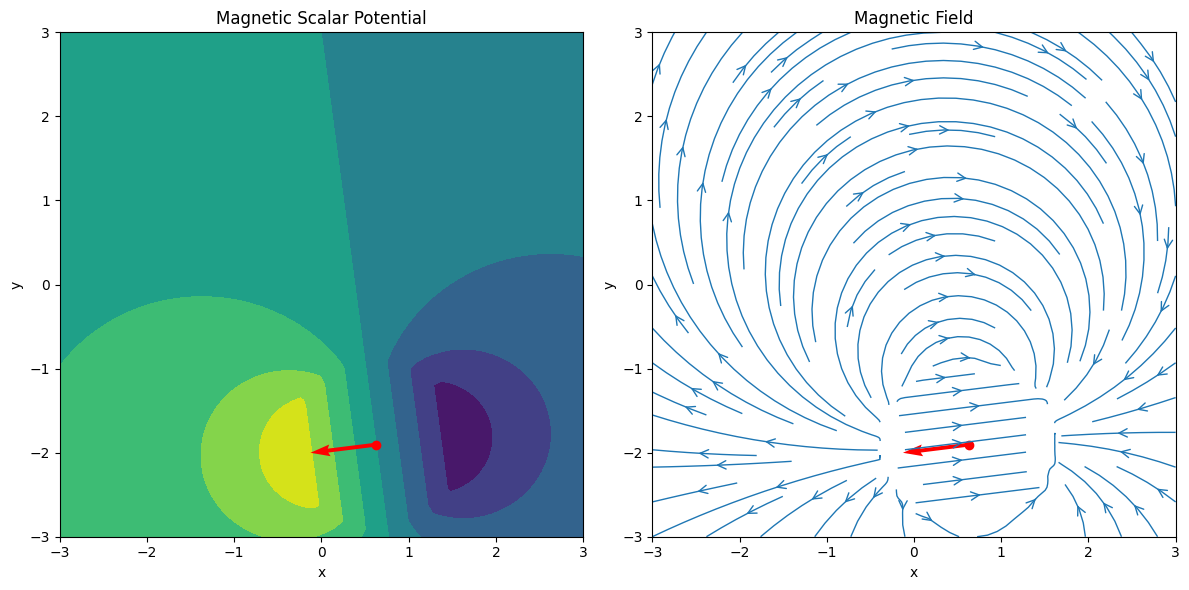

<Figure size 640x480 with 0 Axes>

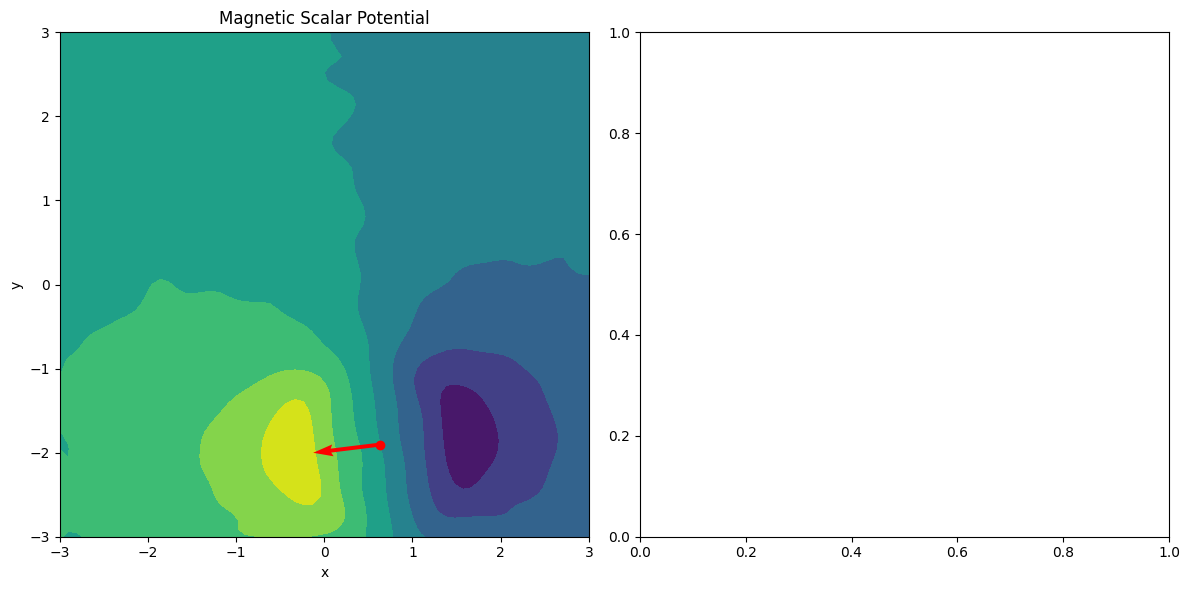

In [22]:
pred_potential = model(m, r0)
tmp_field = lambda m, r0, r: jax.grad(model.fourier)(r, *model.hypermodel(m, r0))
# pred_field = -jax.vmap(
#     jax.vmap(tmp_field, in_axes=(None, None, 0)), in_axes=(0, 0, None)
# )(m, r0, flat_grid)

idx = 0
plots(
    x_grid,
    y_grid,
    m,
    r0,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=idx,
)

plots(
    x_grid,
    y_grid,
    m,
    r0,
    pred_potential.reshape(N, res, res),
    field=None,
    idx=idx,
)


<Figure size 640x480 with 0 Axes>

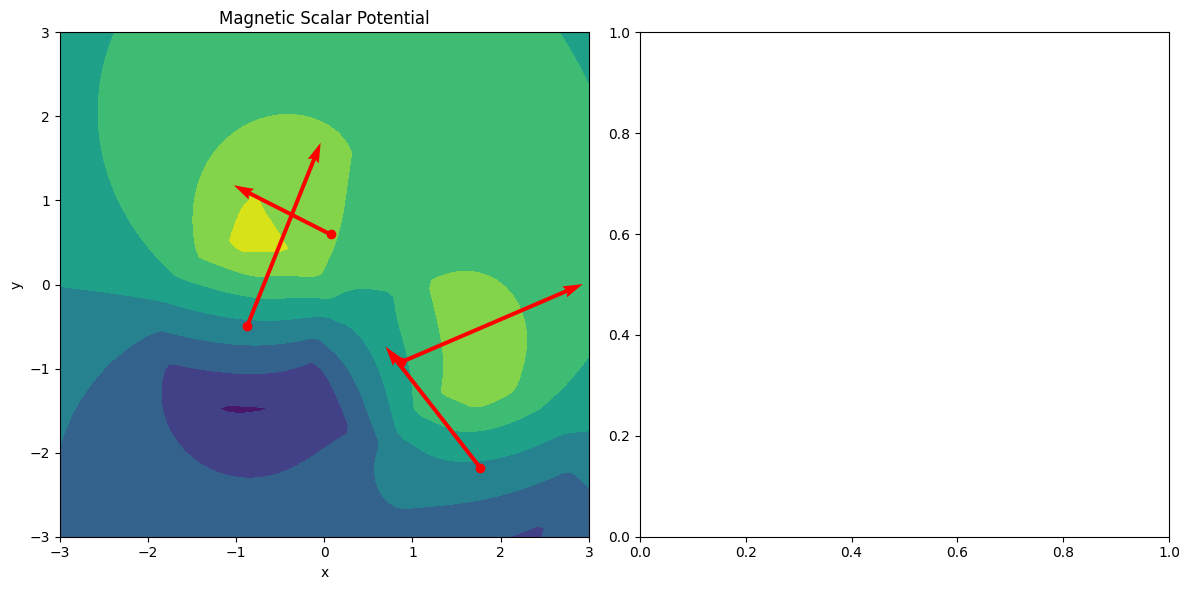

<Figure size 640x480 with 0 Axes>

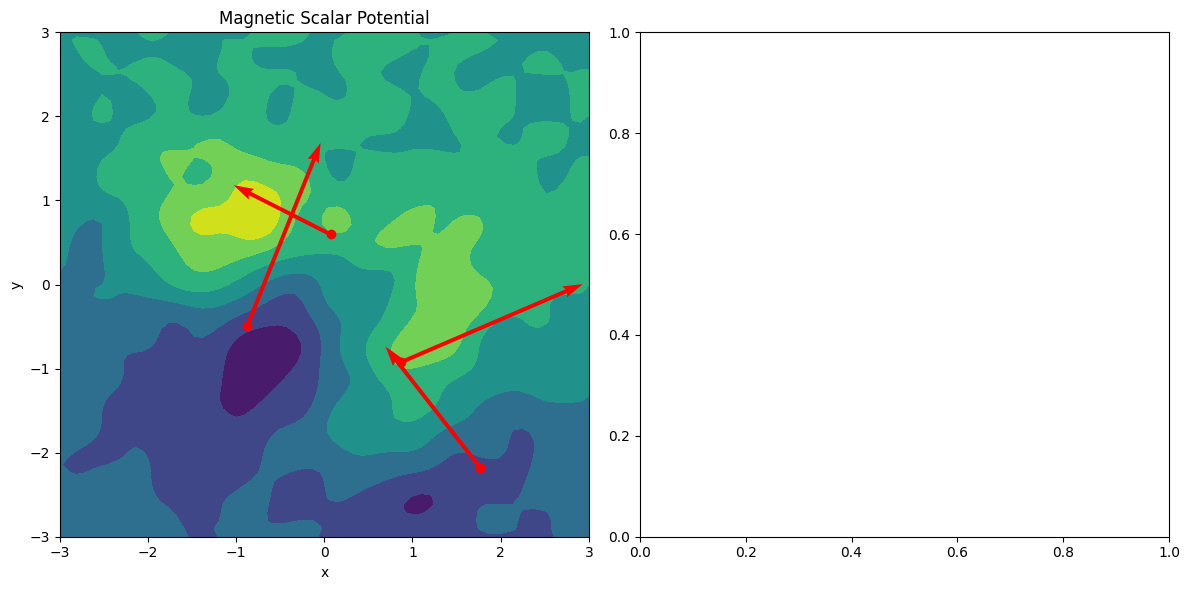

In [23]:
N_val = 1
M_val = 4

key = jr.PRNGKey(100 + 1)
key, sk1, sk2 = jr.split(key, 3)
m_val, r0_val = jnp.split(jr.normal(key=sk1, shape=(N_val, M_val, 4)), 2, axis=-1)
r_val = flat_grid  # jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=sk2)
val_potential = generate_total(scalar_potential, m_val, r0_val, r_val)
pred_potential = model.predict(m_val, r0_val, r_val)

plots(x_grid, y_grid, m_val, r0_val, val_potential.reshape(N_val, res, res), field=None)

plots(
    x_grid, y_grid, m_val, r0_val, pred_potential.reshape(N_val, res, res), field=None
)
